In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
df=pd.read_csv('US_Accidents_March23_sampled_500k.csv')

In [3]:
df.shape

(500000, 46)

In [4]:
df.describe()

,Severity,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
count,500000.000000,500000.000000,500000.000000,279623.000000,279623.000000,500000.000000,489534.000000,370983.000000,488870.000000,491072.000000,488709.000000,463013.000000,357384.000000
mean,2.212748,36.206421,-94.736583,36.273192,-95.776553,0.564317,61.646254,58.229028,64.834921,29.536621,9.091540,7.681347,0.008289
std,0.486661,5.071411,17.405761,5.265333,18.120211,1.774872,19.000133,22.352246,22.826158,1.008666,2.708083,5.431361,0.101865
min,1.000000,24.562117,-124.497420,24.570110,-124.497419,0.000000,-77.800000,-53.200000,1.000000,0.120000,0.000000,0.000000,0.000000
25%,2.000000,33.416823,-117.233047,33.474773,-117.778324,0.000000,49.000000,43.000000,48.000000,29.370000,10.000000,4.600000,0.000000
50%,2.000000,35.832147,-87.794365,36.192669,-88.039013,0.029000,64.000000,62.000000,67.000000,29.860000,10.000000,7.000000,0.000000
75%,2.000000,40.082443,-80.359601,40.181341,-80.252449,0.465000,76.000000,75.000000,84.000000,30.030000,10.000000,10.400000,0.000000
max,4.000000,48.999569,-67.484130,48.998901,-67.484130,193.479996,207.000000,207.000000,100.000000,38.440000,130.000000,822.800000,10.130000


In [5]:
df.isnull().sum()

,0
ID,0
Source,0
Severity,0
Start_Time,0
End_Time,0
Start_Lat,0
Start_Lng,0
End_Lat,220377
End_Lng,220377
Distance(mi),0


In [6]:
# Drop columns with too many missing values or redundant/low-value data

#    'End_Lat',         Mostly missing & redundant with Start_Lat
#    'End_Lng',         Mostly missing & redundant with Start_Lng
#    'Wind_Chill(F)',   70% missing; not useful without accurate imputing
#    'Precipitation(in)',  75% missing; weather condition already conveys rain/snow
#    'Airport_Code',    High-cardinality (thousands of unique values), hard to use directly
#   'Turning_Loop'     All values are False → no variance → no predictive value

df.drop(columns=['End_Lat', 'End_Lng', 'Wind_Chill(F)', 'Precipitation(in)', 'Airport_Code', 'Turning_Loop'], inplace=True)


In [7]:
# Environmental Features: Fill with median
env_cols = ['Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)']
df[env_cols] = df[env_cols].fillna(df[env_cols].median())

In [8]:
median_speed = df['Wind_Speed(mph)'].median()

# Use boolean masking — vectorized and super fast
df.loc[df['Wind_Speed(mph)'].isna() & (df['Wind_Direction'] == 'Calm'), 'Wind_Speed(mph)'] = 0
df['Wind_Speed(mph)'] = df['Wind_Speed(mph)'].fillna(median_speed)


In [9]:
# Categorical Data : Weather and Wind Direction
df['Weather_Condition'] = df['Weather_Condition'].fillna('Clear')
df['Wind_Direction'] = df['Wind_Direction'].fillna('Calm')


In [10]:
# Location related data: Fill with safe values
df['Timezone'] = df['Timezone'].fillna(df['Timezone'].mode()[0])
df['City'] = df['City'].fillna('Unknown')
df['Zipcode'] = df['Zipcode'].fillna('Unknown')

In [11]:
# Twilight Periods: replacing null with Mode + and mapping day and night
twilight_cols = ['Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']
for col in twilight_cols:
    df[col] = df[col].fillna(df[col].mode()[0])
    df[col] = df[col].map({'Day': 1, 'Night': 0})

In [12]:
df['Street'] = df['Street'].fillna('Unknown')


In [13]:
df['Weather_Timestamp'] = df['Weather_Timestamp'].fillna(df['Start_Time'])

In [14]:
df.isna().sum()

,0
ID,0
Source,0
Severity,0
Start_Time,0
End_Time,0
Start_Lat,0
Start_Lng,0
Distance(mi),0
Description,1
Street,0


In [15]:
#Columns Start_Time and End_Time were converted to datetime format:

df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
df['End_Time'] = pd.to_datetime(df['End_Time'], errors='coerce')

#This step ensures accurate handling of date and time values for trend analysis.

In [16]:
# Drop rows where datetime conversion failed
print(df[['Start_Time', 'End_Time']].isna().sum())
df.dropna(subset=['Start_Time', 'End_Time'], inplace=True)

Start_Time    48163
End_Time      48163
dtype: int64


In [17]:
#Use LabelEncoder

#from sklearn.preprocessing import LabelEncoder

#cat_cols = ['State', 'Timezone', 'Weather_Condition', 'Wind_Direction']

#le = LabelEncoder()
#for col in cat_cols:
#    df[col] = le.fit_transform(df[col])

In [18]:
# Number of unique occurrences (distribution) for Severity
df['Severity'].value_counts(normalize=True)

,proportion
Severity,
2,0.777384
3,0.187043
4,0.026113
1,0.009459


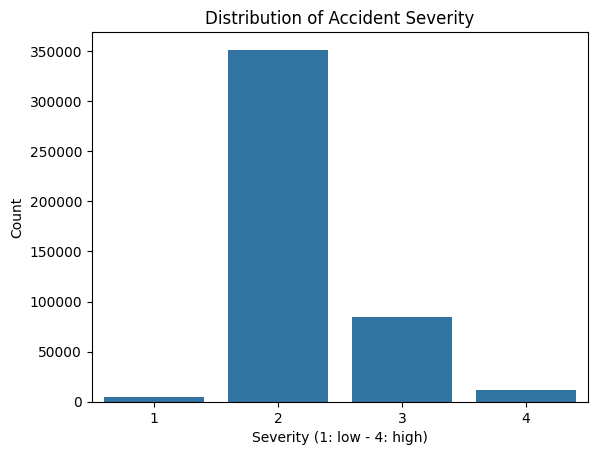

In [19]:
# Distribution plot of accident severity
sns.countplot(x='Severity', data=df)
plt.title("Distribution of Accident Severity")
plt.xlabel("Severity (1: low - 4: high)")
plt.ylabel("Count")
plt.show()


- **Class Imbalance**: Severity 2 is way more common in the dataset, creating an imbalance.
- **Model Bias**: Because of this, the model will probably predict Severity 2 most of the time.
- **Oversampling**: This technique helps by increasing the number of examples from the minority classes, balancing things out.
  
**Why It Matters**: By balancing the dataset, oversampling helps the model learn better across all classes, not just the most frequent one.


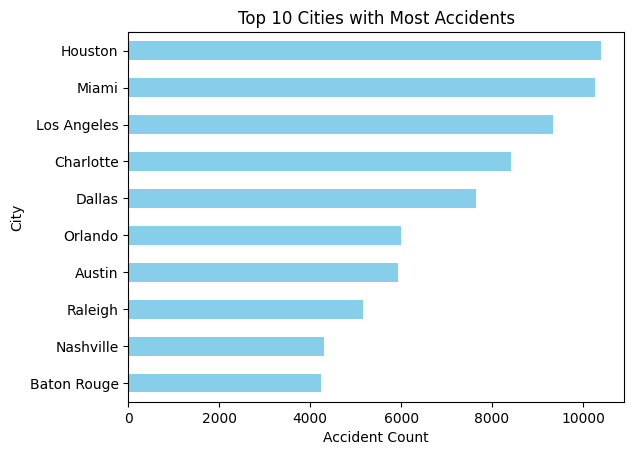

In [20]:
df['City'].value_counts().head(10).plot(kind='barh', color='skyblue')
plt.title('Top 10 Cities with Most Accidents')
plt.xlabel('Accident Count')
plt.gca().invert_yaxis()
plt.show()


- Houston and Miami lead the chart with over 10,000 accidents each, making them the most accident-prone cities in the dataset.

- Los Angeles, Charlotte, and Dallas follow closely, each reporting 7,000–9,000 incidents, showing heavy traffic or urban congestion effects.

- Cities like Orlando and Austin (tourist hubs and tech cities) still show high accident volume, possibly due to transient populations and expanding infrastructure.

- Raleigh, Nashville, and Baton Rouge round out the list with 4,000–5,000+ cases, reflecting consistent urban activity but slightly lower density.

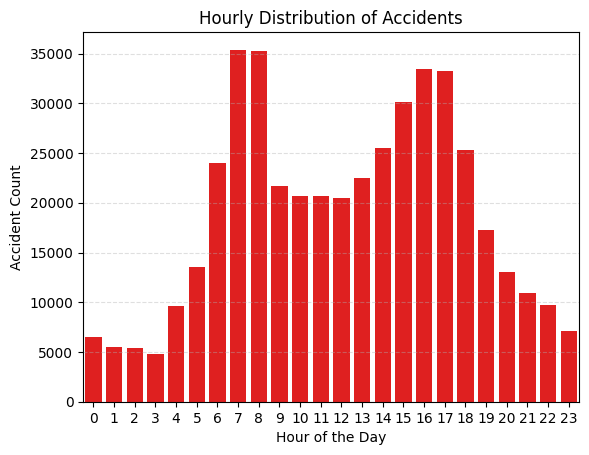

In [21]:
# Count accidents per hour
df['Hour'] = pd.to_datetime(df['Start_Time'], errors='coerce').dt.hour

hourly_counts = df['Hour'].value_counts().sort_index()
sns.barplot(x=hourly_counts.index, y=hourly_counts.values, color='red')
plt.title('Hourly Distribution of Accidents')
plt.xlabel('Hour of the Day')
plt.ylabel('Accident Count')
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()


* Here we can clearly see that the peak hours are 7 AM, 8 AM, 4 PM  most probably due to office rush at general times

* Moderate Rush during 2–5 PM as afternoon traffic builds up.

* & Lowest from 1–3 AM as minimal traffic, where fewer incidents are observed.

Weekday
Monday       71717
Tuesday      75862
Wednesday    77482
Thursday     77404
Friday       80537
Saturday     37447
Sunday       31388
Name: count, dtype: int64


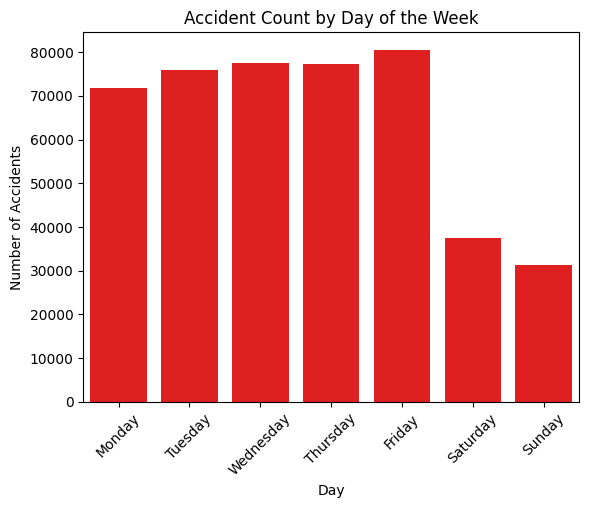

In [22]:
# Weekday Accidents
df['Weekday'] = df['Start_Time'].dt.day_name()

weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_counts = df['Weekday'].value_counts().reindex(weekday_order)
print(weekday_counts)

sns.barplot(x=weekday_counts.index, y=weekday_counts.values, color="red")
plt.title('Accident Count by Day of the Week')
plt.xlabel('Day')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45)
plt.show()


* Most accidents occur on Friday (80,537), followed by Wednesday and Thursday.

* Monday–Friday consistently show high accident volumes — typical of weekday traffic and work commutes.

* Weekends (Saturday: 37,447, Sunday: 31,388) have significantly fewer accidents, likely due to lower road activity.

* Conclusion: Accidents are strongly concentrated on weekdays, especially toward the end of the workweek.



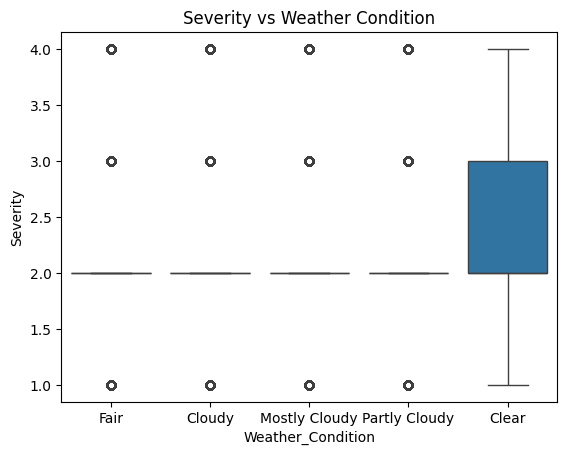

In [23]:
top_weather = df['Weather_Condition'].value_counts().head(5).index
subset = df[df['Weather_Condition'].isin(top_weather)]
sns.boxplot(data=subset, x='Weather_Condition', y='Severity')
plt.title('Severity vs Weather Condition')
plt.show()


This Graph isto show what was the Weather Condition at which serverity 2

Weather_Condition
Fair                143041
Clear                62248
Mostly Cloudy        59467
Cloudy               46463
Partly Cloudy        41012
Overcast             24896
Light Rain           20752
Scattered Clouds     13029
Light Snow            7186
Fog                   5744
Name: count, dtype: int64


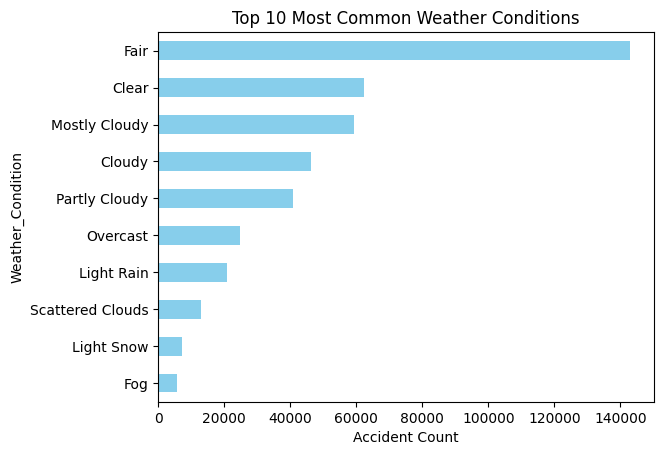

In [24]:
# Weather Condition Accidents
top_weather = df['Weather_Condition'].value_counts().head(10)
print(top_weather)

top_weather.plot(kind='barh', color='skyblue')
plt.title("Top 10 Most Common Weather Conditions")
plt.xlabel("Accident Count")
plt.gca().invert_yaxis()
plt.show()


---
- Fair weather dominates with over 143K accidents, followed by Clear and Mostly Cloudy.
---
- Surprisingly, bad weather like Light Rain, Fog, and Snow accounts for far fewer accidents.
---
- This suggests that most accidents occur in good or normal weather, likely because that's when most people are driving.
---
- Conclusion: Weather alone doesn’t cause accidents — traffic volume and human factors during good weather are major contributors.
---

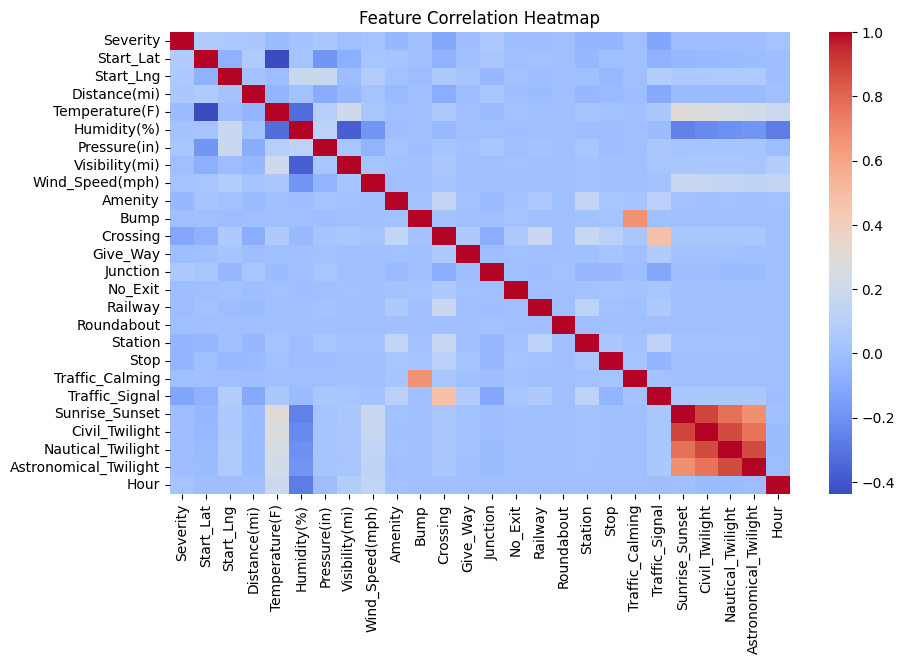

In [25]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), cmap='coolwarm', annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

---
* Here we can see that thereis strong collection of
---
- Sunrise_Sunset
- Civil_Twilight
- Nautical_Twilight
- Astronomical_Twilight
---




So let's plot that Graph

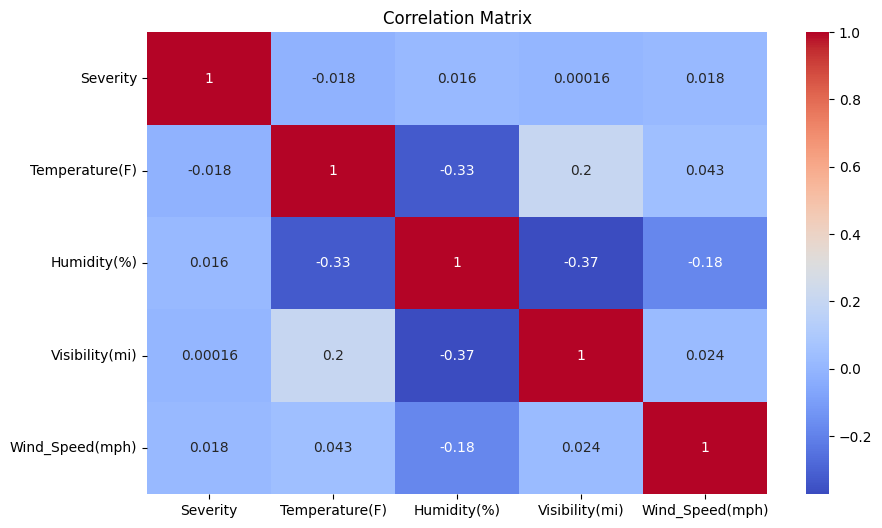

In [26]:
# Correlation matrix
cols = ['Severity', 'Temperature(F)', 'Humidity(%)', 'Visibility(mi)', 'Wind_Speed(mph)']
plt.figure(figsize=(10, 6))
sns.heatmap(df[cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


---
Here we can see that:

---

* There is no strong linear correlation between accident severity and basic weather features.

* Humidity and visibility are inversely related, which makes sense — fog, rain, or snow tend to reduce visibility.

* While individual weather variables don’t predict severity well, their combined or non-linear impact might still influence accidents. Tree-based models (like Random Forest or XGBoost) are better suited to capture these patterns.



---



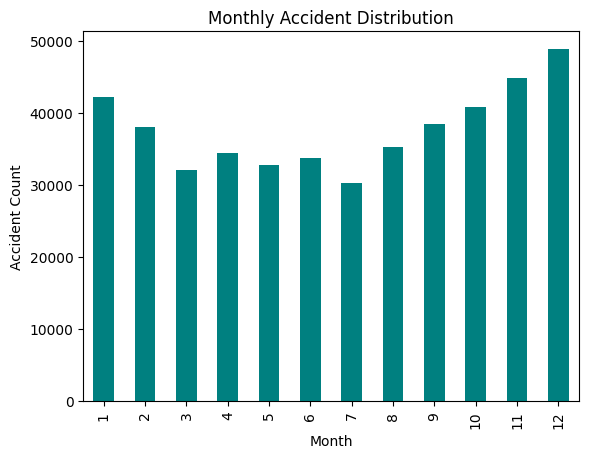

In [27]:
monthly = df['Start_Time'].dt.month.value_counts().sort_index()
monthly.plot(kind='bar', color='teal')
plt.title('Monthly Accident Distribution')
plt.xlabel('Month')
plt.ylabel('Accident Count')
plt.show()


- December shows the highest number of accidents, followed by November and January.

- Summer months (June–August) have relatively fewer incidents.

- A steady rise is seen from September to December, possibly due to holiday travel, adverse weather, and shorter daylight.

# Feature Engineering

In [28]:
# Time-based features from Start_Time
df['Hour'] = df['Start_Time'].dt.hour
df['Day'] = df['Start_Time'].dt.day
df['Month'] = df['Start_Time'].dt.month
df['Year'] = df['Start_Time'].dt.year
df['Weekday'] = df['Start_Time'].dt.dayofweek  # 0 = Monday
df['Is_Weekend'] = df['Weekday'].apply(lambda x: 1 if x >= 5 else 0)


In [29]:
df['Duration_Min'] = (df['End_Time'] - df['Start_Time']).dt.total_seconds() / 60
df = df[df['Duration_Min'] >= 0]

In [30]:
#Day Night Features
df['Is_Night'] = df['Sunrise_Sunset'].apply(lambda x: 1 if x == 'Night' else 0)


In [31]:
#Text Length Features (Optional)

df['Description_Length'] = df['Description'].apply(lambda x: len(str(x)))
df['Street_Length'] = df['Street'].apply(lambda x: len(str(x)))

In [32]:
def classify_columns(df, cat_threshold=10, car_threshold=20):
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    num_but_cat = [col for col in numerical_cols if df[col].nunique() < cat_threshold]

    cat_but_car = [col for col in categorical_cols if df[col].nunique() > car_threshold]

    categorical_cols_final = list(set(categorical_cols + num_but_cat) - set(cat_but_car))

    numerical_cols_final = [col for col in numerical_cols if col not in num_but_cat]

    return categorical_cols_final, numerical_cols_final, cat_but_car
cat_cols, num_cols, cat_but_car = classify_columns(df)
print("Categorical Columns:", cat_cols)
print("Numerical Columns:", num_cols)
print("High Cardinality Categorical Columns:", cat_but_car)


Categorical Columns: ['Is_Night', 'Source', 'Nautical_Twilight', 'Is_Weekend', 'Sunrise_Sunset', 'Astronomical_Twilight', 'Timezone', 'Country', 'Civil_Twilight', 'Severity']
Numerical Columns: ['Start_Lat', 'Start_Lng', 'Distance(mi)', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Duration_Min', 'Description_Length', 'Street_Length']
High Cardinality Categorical Columns: ['ID', 'Description', 'Street', 'City', 'County', 'State', 'Zipcode', 'Weather_Timestamp', 'Wind_Direction', 'Weather_Condition']


In [33]:
a_states = df['State'].value_counts().nlargest(10).index
df['a_states'] = df['State'].apply(lambda x: x if x in a_states else 'Other')


* This keeps only the top 10 states with the most accident records

* Labels all other states as 'Other'

* Reduces dimensionality while preserving signal from major contributors

In [34]:
# While predicting the target variable, meaningless columns are removed from the dataset
df = df.drop(['ID', 'Source', 'Description', 'Street', 'Country', 'Zipcode', 'City', 'County', 'End_Time', 'Timezone'], axis=1)

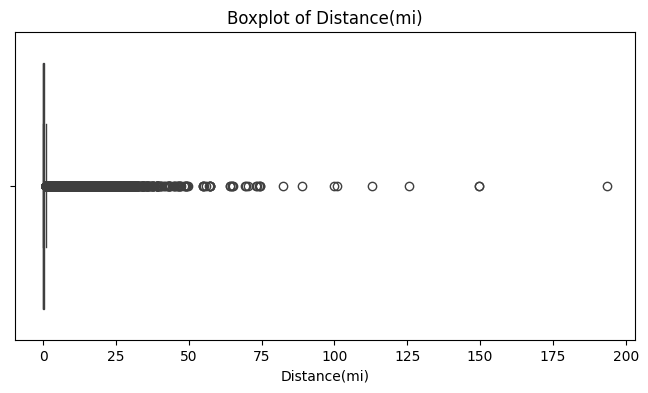

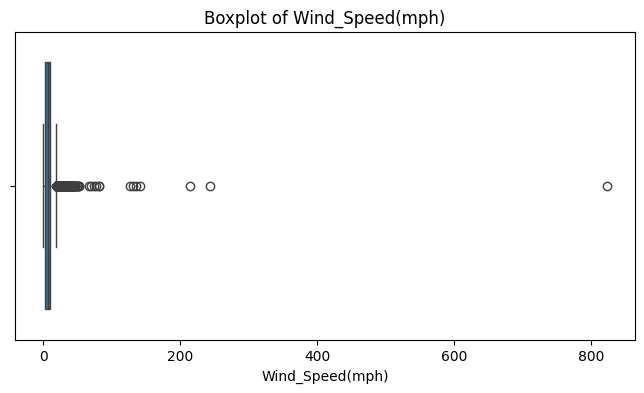

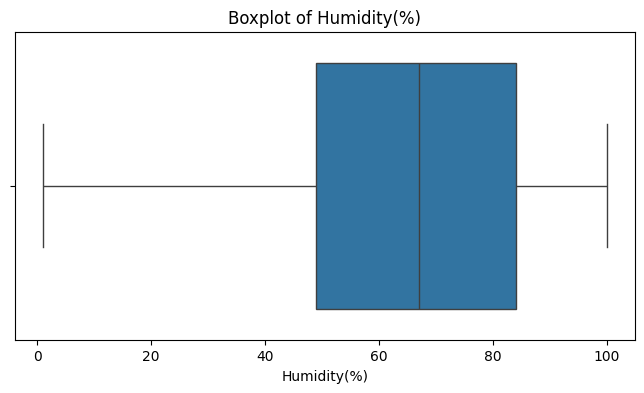

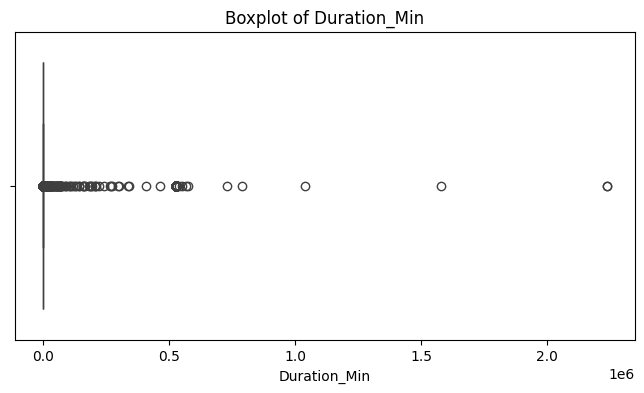

In [35]:
for col in ['Distance(mi)', 'Wind_Speed(mph)', 'Humidity(%)', 'Duration_Min']:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()


In [36]:
# function to determine outlier thresholds
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


In [37]:
def check_outliers(dataframe, col_name):
    q1 = dataframe[col_name].quantile(0.25)
    q3 = dataframe[col_name].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    has_outliers = dataframe[(dataframe[col_name] < lower_bound) | (dataframe[col_name] > upper_bound)].shape[0] > 0
    return has_outliers




In [38]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    return dataframe[(dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit)].any().any()
for col in num_cols:
    print(col, check_outlier(df, col))


/tmp/ipython-input-38-1915629947.py:3: FutureWarning: 'any' with datetime64 dtypes is deprecated and will raise in a future version. Use (obj != pd.Timestamp(0)).any() instead.
  return dataframe[(dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit)].any().any()
/tmp/ipython-input-38-1915629947.py:3: FutureWarning: 'any' with datetime64 dtypes is deprecated and will raise in a future version. Use (obj != pd.Timestamp(0)).any() instead.
  return dataframe[(dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit)].any().any()
/tmp/ipython-input-38-1915629947.py:3: FutureWarning: 'any' with datetime64 dtypes is deprecated and will raise in a future version. Use (obj != pd.Timestamp(0)).any() instead.
  return dataframe[(dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit)].any().any()
/tmp/ipython-input-38-1915629947.py:3: FutureWarning: 'any' with datetime64 dtypes is deprecated and will raise in a future version. Use (obj != pd.Timestamp(0)).any(

Start_Lat False
Start_Lng False
Distance(mi) True
Temperature(F) True
Humidity(%) False
Pressure(in) True
Visibility(mi) True
Wind_Speed(mph) True
Duration_Min True
Description_Length True
Street_Length True


/tmp/ipython-input-38-1915629947.py:3: FutureWarning: 'any' with datetime64 dtypes is deprecated and will raise in a future version. Use (obj != pd.Timestamp(0)).any() instead.
  return dataframe[(dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit)].any().any()
/tmp/ipython-input-38-1915629947.py:3: FutureWarning: 'any' with datetime64 dtypes is deprecated and will raise in a future version. Use (obj != pd.Timestamp(0)).any() instead.
  return dataframe[(dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit)].any().any()
/tmp/ipython-input-38-1915629947.py:3: FutureWarning: 'any' with datetime64 dtypes is deprecated and will raise in a future version. Use (obj != pd.Timestamp(0)).any() instead.
  return dataframe[(dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit)].any().any()
/tmp/ipython-input-38-1915629947.py:3: FutureWarning: 'any' with datetime64 dtypes is deprecated and will raise in a future version. Use (obj != pd.Timestamp(0)).any(

In [39]:
def remove_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    return dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
for col in num_cols:
    data = remove_outlier(df, col)


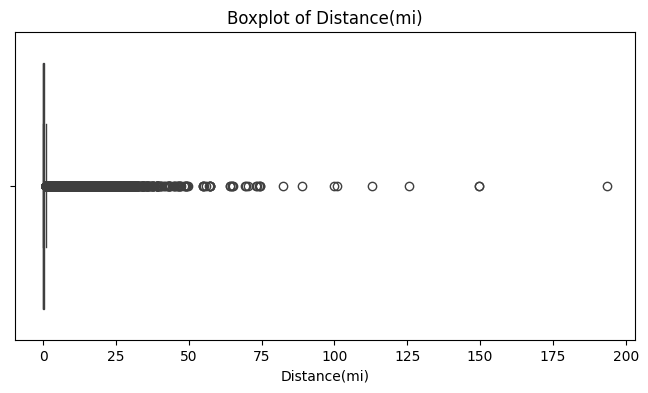

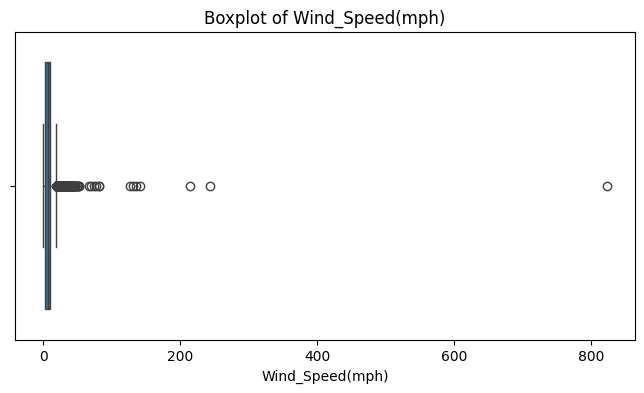

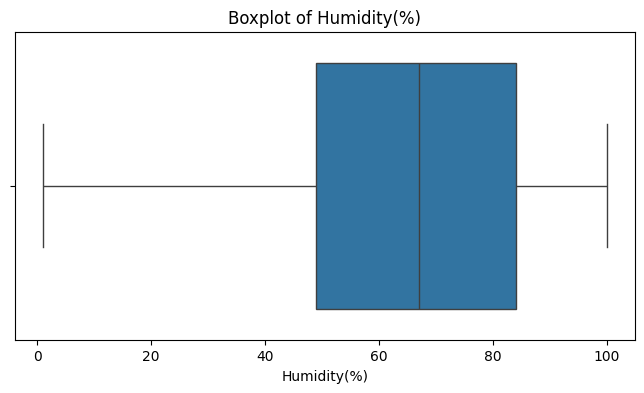

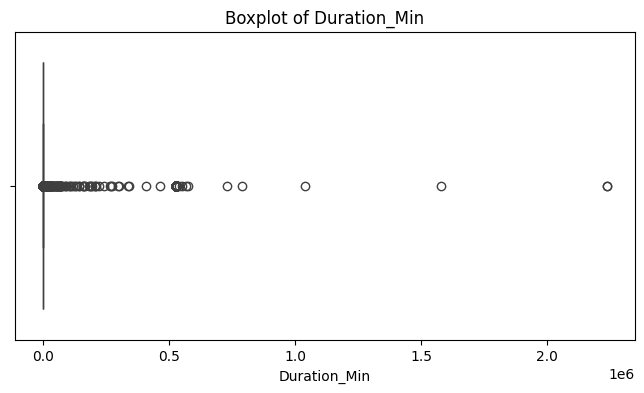

In [40]:
for col in ['Distance(mi)', 'Wind_Speed(mph)', 'Humidity(%)', 'Duration_Min']:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()


In [41]:
# Dropping variables that contain excessive or redundant information
data = df.drop(columns=['Start_Time', 'State'])


In [42]:
# Missing data check
missing = data.isnull().sum().sort_values(ascending=False)
print(missing[missing > 0])


Series([], dtype: int64)


# Encoding

In [43]:
# Label encoding for day-night related variables
label_cols = ['Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']
le = LabelEncoder()
for col in label_cols:
    data[col] = le.fit_transform(data[col])


In [44]:
#One-Hot Encoding for categorical variables
data=pd.get_dummies(data,columns=['Weather_Condition','a_states','Weekday'])

# Modelling

In [45]:
# The column we want to predict
y = data['Severity']

# We remove the target variable from the feature set
X = data.drop('Severity', axis=1)


In [46]:
# Encode only object (string) columns
for col in X.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))


In [47]:
X = X.drop(columns=["Weather_Timestamp"])

Train-test split is a model validation technique that divides a dataset into a training set and a test set.

In [48]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [50]:
from sklearn.feature_selection import SelectFromModel

rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
sfm = SelectFromModel(rf, threshold='median')  # Select top 50% features

sfm.fit(X_train, y_train)

selected_features = X.columns[sfm.get_support()]
X_train_sfm = sfm.transform(X_train)
X_test_sfm = sfm.transform(X_test)


In [51]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.01, random_state=42)
lasso.fit(X_train_scaled, y_train)

coef = pd.Series(lasso.coef_, index=X.columns)
selected_lasso_features = coef[coef != 0].index.tolist()

print("Selected features:", selected_lasso_features)


Selected features: ['Start_Lat', 'Start_Lng', 'Crossing', 'Junction', 'Station', 'Stop', 'Traffic_Signal', 'Hour', 'Month', 'Year', 'Is_Weekend', 'Description_Length', 'Street_Length', 'a_states_Other', 'a_states_SC']


`Lasso Selected: ['Start_Lat', 'Start_Lng', 'Distance(mi)', 'Temperature(F)', 'Pressure(in)', 'Wind_Speed(mph)', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Sunrise_Sunset', 'Nautical_Twilight', 'Astronomical_Twilight', 'Hour', 'Weather_Condition_Clear', 'Weather_Condition_Cloudy', 'Weather_Condition_Foggy', 'Weather_Condition_Other', 'Weather_Condition_Rainy', 'Weather_Condition_Snowy', 'a_states_FL', 'a_states_MN', 'a_states_NC', 'a_states_NY', 'a_states_OR', 'a_states_Other', 'a_states_PA', 'a_states_SC', 'a_states_TX', 'a_states_VA', 'Weekday_Friday', 'Weekday_Monday', 'Weekday_Saturday', 'Weekday_Sunday', 'Weekday_Tuesday', 'Weekday_Wednesday']a`

In [68]:
from imblearn.over_sampling import SMOTE

# Use features selected by Lasso
X_train_lasso = X_train[selected_lasso_features]
X_test_lasso = X_test[selected_lasso_features]

# Scale the Lasso feature-selected data
scaler_lasso = StandardScaler()
X_train_lasso_scaled = scaler_lasso.fit_transform(X_train_lasso)
X_test_lasso_scaled = scaler_lasso.transform(X_test_lasso)

# Convert scaled data back to DataFrames to retain feature names
X_train_lasso_scaled_df = pd.DataFrame(X_train_lasso_scaled, columns=selected_lasso_features)
X_test_lasso_scaled_df = pd.DataFrame(X_test_lasso_scaled, columns=selected_lasso_features)


# Now apply SMOTE
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train_lasso_scaled_df, y_train)

In [70]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Define your models (if not already defined)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# from lightgbm import LGBMClassifier # Temporarily removed LightGBM


models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced'),
    "Random Forest": RandomForestClassifier(class_weight='balanced'),
    # "LightGBM": LGBMClassifier(random_state=42) # Temporarily removed LightGBM
}

# Train and evaluate
results = []

for name, model in models.items():
    model.fit(X_train_bal, y_train_bal)
    # Use the scaled and Lasso feature-selected test data for prediction
    y_pred = model.predict(X_test_lasso_scaled_df)

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='weighted'),
        "Recall": recall_score(y_test, y_pred, average='weighted'),
        "F1-Score": f1_score(y_test, y_pred, average='weighted')
    })

# Show results
results_df = pd.DataFrame(results)
results_df.sort_values(by="F1-Score", ascending=False, inplace=True)
results_df.reset_index(drop=True, inplace=True)

print(results_df)

                 Model  Accuracy  Precision    Recall  F1-Score
0        Random Forest  0.855887   0.855181  0.855887  0.855185
1        Decision Tree  0.788323   0.812495  0.788323  0.798874
2  Logistic Regression  0.422946   0.772277  0.422946  0.514188


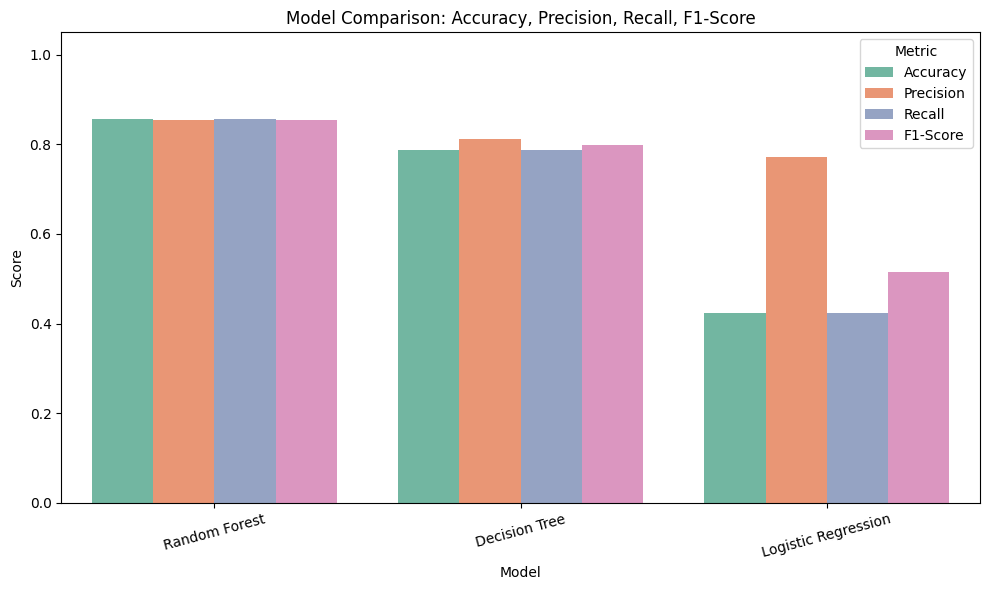

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Your results DataFrame
results_df = pd.DataFrame({
    "Model": ["Random Forest", "Decision Tree", "Logistic Regression"],
    "Accuracy": [0.855887, 0.788323, 0.422946],
    "Precision": [0.855181, 0.812495, 0.772277],
    "Recall": [0.855887, 0.788323, 0.422946],
    "F1-Score": [0.855185, 0.798874, 0.514188]
})

# Melt the DataFrame for seaborn plotting
results_melted = results_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=results_melted, x='Model', y='Score', hue='Metric', palette='Set2')
plt.title('Model Comparison: Accuracy, Precision, Recall, F1-Score')
plt.ylim(0, 1.05)
plt.ylabel('Score')
plt.legend(title='Metric')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()
